<h1 style="font-size:4em; "> Max-Cut Problem </h1>

First, we need to import nessesory library 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

#helper function from utill
from utill import graph as ut


Let start the simple graph with 5 nodes

In [2]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)

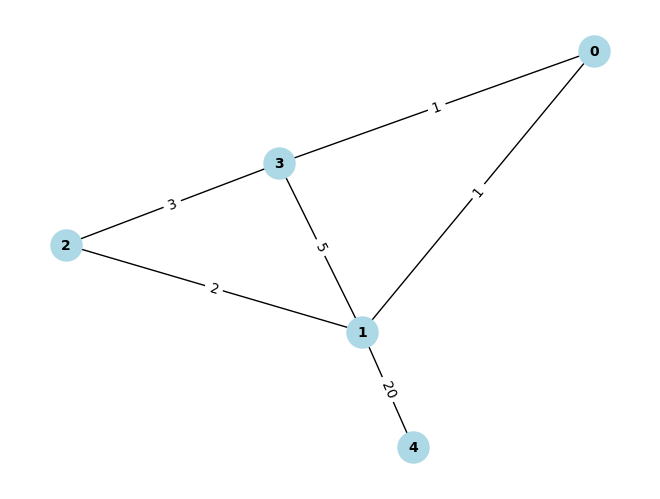

In [3]:
ut.draw_graph(G)

The MaxCut problem aims to determine how to partition (or "cut") the vertices of a graph into two disjoint subsets such that the sum of the weights of the edges crossing between the subsets is maximized.

For this graph, the maxcut bitstring is [1, 0, 0, 1, 1]

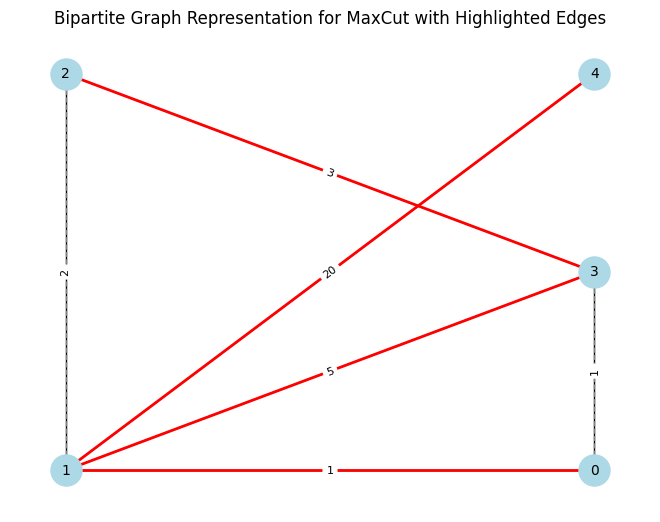

In [4]:
bitstring = [1, 0, 0, 1, 1]
ut.draw_partition_graph(G, bitstring)

So the final answer for maxcut is 29

<h1 style="font-size:3em; "> Tranform to QUBO </h1>

To generalize, Mathematical Formulation

# MaxCut Problem Formulation

Given an undirected graph $G = (V, E)$ with edge weights $w_{ij}$ for $(i, j) \in E$, the MaxCut problem can be formulated as:

$$
\text{Maximize: } \frac{1}{2} \sum_{(i, j) \in E} w_{ij} (1 - x_i x_j)
$$

**Subject to:**

$$
x_i \in \{-1, 1\} \quad \forall i \in V
$$

**Where:**

- $x_i \in \{-1, 1\}$: Indicates the set to which vertex $i$ belongs.
  - $x_i = 1$: Vertex $i$ is in one partition.
  - $x_i = -1$: Vertex $i$ is in the other partition.
- $w_{ij}$: The weight of the edge between vertices $i$ and $j$.


# QUBO Formulation for MaxCut

The **Quadratic Unconstrained Binary Optimization (QUBO)** formulation for the MaxCut problem can be described as follows:

Given an undirected graph $G = (V, E)$ with edge weights $w_{ij}$, the goal is to partition the vertices $V$ into two disjoint subsets $S$ and $T$ such that the weight of the cut is maximized.

### Variables
- Let $x_i \in \{0, 1\}$ for each vertex $i \in V$:
  - $x_i = 0$: Vertex $i$ is in one subset.
  - $x_i = 1$: Vertex $i$ is in the other subset.

### Objective Function
The objective function can be written as:

$$
\text{Maximize: } \sum_{(i, j) \in E} w_{ij} \, x_i (1 - x_j) + w_{ij} \, x_j (1 - x_i)
$$

This simplifies to:

$$
\text{Maximize: } \sum_{(i, j) \in E} w_{ij} \, x_i x_j - \frac{1}{2} \sum_{(i, j) \in E} w_{ij}.
$$

### QUBO Matrix Form
In QUBO, we minimize an energy function represented as:

$$
\text{Minimize: } H(x) = x^T Q x
$$

Where:
- $Q$ is the QUBO matrix,
- $x$ is the vector of binary variables.

For MaxCut:

$$
Q_{ij} =
\begin{cases}
-w_{ij} & \text{if } (i, j) \in E, \\
\sum_{(i, k) \in E} w_{ik} & \text{if } i = j, \\
0 & \text{otherwise.}
\end{cases}
$$

### Example

For a simple graph:

- **Graph:** $G = (V, E)$ with:
  - $V = \{1, 2, 3\}$,
  - $E = \{(1, 2), (2, 3)\}$,
  - Weights: $w_{12} = 3$, $w_{23} = 2$.



In [3]:
n = 3
G = nx.Graph()
V = range(1, n+1)
G.add_nodes_from(V)
E = [(1, 2, 3), (2, 3, 2)]
G.add_weighted_edges_from(E)

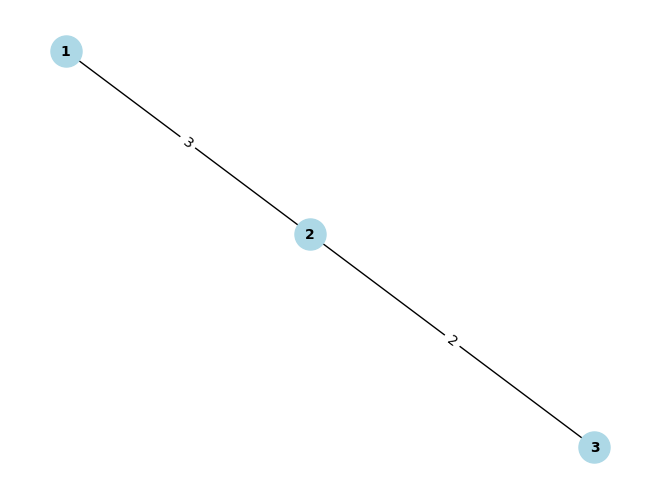

In [4]:
ut.draw_graph(G)

The QUBO matrix $Q$ is:

$$
Q =
\begin{bmatrix}
3 & -3 & 0 \\
-3 & 5 & -2 \\
0 & -2 & 2
\end{bmatrix}.
$$